dependencies

In [2]:
#check for possible breakpoints in contractions
#pip install contractions
# Plotting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.getcwd())

# Text processing
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
import contractions
import re
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

# Model-related
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer


C:\Space\Facultate\Master\AN I\BigData\Proiect\dev


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cosmin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Cosmin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Cosmin\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


### Load the dataset
#### Dataset: https://www.kaggle.com/code/ddosad/twitter-sentiment-analysis-eda-ml/input

In [4]:
columns = ['textID', 'text', 'selected_text', 'sentiment'] # Define the column names for the DataFrame
encoding = 'ISO-8859-1' # Define the encoding format for reading the CSV file

df = pd.read_csv('Tweets.csv', encoding=encoding)

# Display the column names of the DataFrame
print('DataFrame Columns:', df.columns)

# Display the shape (number of rows and columns) of the DataFrame
print('DataFrame Shape:', df.shape)

# Display the first 5 rows of the DataFrame to get an overview of the data
df.head(5)


DataFrame Columns: Index(['textID', 'text', 'selected_text', 'sentiment'], dtype='object')
DataFrame Shape: (27481, 4)


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going there","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


### Sanitized data

In [6]:
sent_text = df[['text', 'sentiment']].copy()

sent_text['sentiment'].unique()

# Transform the labels from strings to integers
# 0 - negative
# 1 - positive
# 2 - neutral

sent_text['sentiment'] = sent_text['sentiment'].replace('negative', 0)
sent_text['sentiment'] = sent_text['sentiment'].replace('positive', 1)
sent_text['sentiment'] = sent_text['sentiment'].replace('neutral', 2)

pos_sent_text = sent_text[sent_text['sentiment'] == 1]
neg_sent_text = sent_text[sent_text['sentiment'] == 0]
neut_sent_text = sent_text[sent_text['sentiment'] == 2]

subset_len = 20000 # Subset length used for testing 
pos_sent_text = pos_sent_text.iloc[::] #:subset_len
neg_sent_text = neg_sent_text.iloc[::] #:subset_len
neut_sent_text = neut_sent_text.iloc[::] #:subset_len
dataset = pd.concat([pos_sent_text, neg_sent_text, neut_sent_text])

# Convert the obj content to str / int
dataset.text = dataset.text.astype(str)
dataset.sentiment = dataset.sentiment.astype(int)


#Good to do :
##Check for null values 
#dataset.isnull().sum()
##Check for duplicates
#dataset.duplicated().sum()


### Example of each subset tweets

In [8]:
print('\nPositive tweets: ')
print(pos_sent_text.tail())
print('\nNegative tweets: ')
print(neg_sent_text.tail())
print('\nNeutral tweets: ')
print(neut_sent_text.tail())


Positive tweets: 
                                                    text  sentiment
27467  morning twit-friends! welcome to my new followers          1
27474  So I get up early and I feel good about the da...          1
27475                                     enjoy ur night          1
27478   Yay good for both of you. Enjoy the break - y...          1
27479                         But it was worth it  ****.          1

Negative tweets: 
                                                    text  sentiment
27464  rec game....trying not to cry...the pain is to...          0
27470   lol i know  and haha..did you fall asleep?? o...          0
27472  http://twitpic.com/663vr - Wanted to visit the...          0
27476   wish we could come see u on Denver  husband l...          0
27477   I`ve wondered about rake to.  The client has ...          0

Neutral tweets: 
                                                    text  sentiment
27468  few grilled mushrooms and olives, feta cheese ...    

### If we were to make the WordCloud now, most of the words would be wrongly categorized, so we will proceed with processing.
### To do that we made a utility class for preprocessing the tweets
#### The preprocessing pipeline involves three main steps:
1. Sanitization
    1. Remove URLs and mentions like '@user'.
    2. Convert all text to lowercase for uniformity.
    3. Replace misused symbols (e.g., convert backticks \` to apostrophes ').
    4. Expand contractions (e.g., "don't" → "do not").
    5. Replace common slang words using a predefined dictionary.
2. Slang conversion (convert grammar errors and slang to valid words before further filtering)
    1. Remove punctuation.
    2. Convert digits used as letters (e.g., "gr8" → "great").
    3. Remove repeating characters in invalid words (e.g., "hiiiii" → "hi").
3. Final processing
    1. Remove stopwords (common words like "the", "and").
    2. Apply lemmatization (reduce words to their base form, e.g., "running" → "run").
    3. Apply stemming (reduce words to their root form, e.g., "runner" → "run").
    4. Tokenize the text (split sentences into individual words or tokens).

In [10]:
import nltk
nltk.download('words')

class TextCleaner():
  
    STOP_WORDS = set(stopwords.words('english')) # set of English stop words
    PUNCT_SYMBOLS = set(string.punctuation) # set of English punctuation symbols
    LEMMATIZER = WordNetLemmatizer() # lemmatizer for reducing words to their base form  runner -> run
    TOKENIZER = RegexpTokenizer(r'\w+') # tokenizer to split text into words based on regular expression
    STEMMER = PorterStemmer() # stemmer for reducing words to their root form 
    ENG_VOCAB = set(nltk.corpus.words.words()) # Set of english vocabulary words

    #most common slang words - keep tracking for dynamic expand
    SLANG_WORD_DICT = {
    'gr8': 'great',
    'm8': 'mate',
    'omg': 'oh my god',
    'lol': 'laugh out loud',
    'btw': 'by the way',
    'idk': "i don't know",
    'tbh': 'to be honest',
    'imo': 'in my opinion',
    'imho': 'in my humble opinion',
    'fyi': 'for your information',
    'brb': 'be right back',
    'afk': 'away from keyboard',
    'ttyl': 'talk to you later',
    'tysm': 'thank you so much',
    'np': 'no problem',
    'rn': 'right now',
    'bf': 'boyfriend',
    'gf': 'girlfriend',
    'nvm': 'never mind',
    'bc': 'because',
    'cuz': 'because',
    'thx': 'thanks',
    'pls': 'please',
    'plz': 'please',
    'u': 'you',
    'r': 'are',
    'y': 'why',
    'k': 'okay',
    'kk': 'okay okay',
    'idc': "i don't care",
    'irl': 'in real life',
    'asap': 'as soon as possible',
    'tho': 'though',
    'dm': 'direct message',
    'pm': 'private message',
    'fb': 'facebook',
    'ig': 'instagram',
    'yt': 'youtube',
    'tmrw': 'tomorrow',
    'rip': 'rest in peace',
    'sry': 'sorry',
    'nbd': 'no big deal',
    'tba': 'to be announced',
    'tbd': 'to be determined'
}
    # dictionary mapping numeric characters to their potential letter substitutes
    DIGIT_LETTER_DICT = {
    '0': 'o',    # Examples: 'n00b', 'l00k'
    '1': 'i',    # Examples: 'w1n', 'sk1llz'
    '2': 'to',   # Examples: '2day', 'l8r2nite'
    '3': 'e',    # Examples: 'l33t', 'sw33t'
    '4': 'a',    # Examples: '4ever', 'l4ter'
    '5': 's',    # Examples: '5up', 'ye5'
    '6': 'g',    # Examples: '6ood', '6ame'
    '7': 't',    # Examples: '7ime', 'wa7ch'
    '8': 'ate',  # Examples: 'gr8', 'l8r'
    '9': 'g',    # Examples: '9ame', '9one'
    '@': 'a',    # Examples: 'b@d', 'r@t'
    '$': 's',    # Examples: 'ca$h', 'fa$t'
    '+': 't',    # Examples: 'ho+', 'ge+'
    '!': 'i',    # Examples: 'h!t', 'b!g'
    'z': 's'     # Examples: 'skillz', 'dollaz'
}

    MISUSED_SYMBOLS_DICT = {
        r'`': '\''
    }

    @classmethod
    def replace_slang_words(cls, text):
        return ' '.join([w if w in cls.ENG_VOCAB else cls.SLANG_WORD_DICT.get(w, w) for w in text.split()])

    @classmethod
    def replace_digit_letters(cls, text):
        return ''.join([cls.DIGIT_LETTER_DICT.get(i, i) for i in text])
    
    @classmethod
    def remove_invalid_repeating_letters(cls, text):
        return ' '.join([w if w in cls.ENG_VOCAB else re.sub(r'(.)\1+', r'\1', w) for w in text.split()])

    @classmethod
    def clean_text(cls, text):
        # remove URLs
        data = re.sub(r'https?://\S+|www\.\S+', '', text, flags=re.IGNORECASE)
        # remove mentions 
        data = re.sub(r'@[^\\s]+', '', data)
        # lowercase
        data = data.lower()
        # missused
        for k, v in cls.MISUSED_SYMBOLS_DICT.items():
            data = re.sub(k, v, data)
        # contractions
        data = contractions.fix(data)
        # replace common slangs
        data = cls.replace_slang_words(data)
        # punctuation remover
        data = ''.join(ch for ch in data if ch not in cls.PUNCT_SYMBOLS)
        # digits to letters
        data = cls.replace_digit_letters(data)
        # repeating characters in words
        data = cls.remove_invalid_repeating_letters(data)
        # remove words with digits
        data = re.sub(r'\w*\d\w*', '', data)
        # remove stopwords
        data = ' '.join([word for word in data.split() if word not in cls.STOP_WORDS])
        # lemmmatize
        data = ' '.join([cls.LEMMATIZER.lemmatize(word) for word in data.split()])
        # normal stemming
        # data = ' '.join([cls.STEMMER.stem(word) for word in data.split()])
        
        # stemming only for words who are not in eng dict
        data = ' '.join([
            cls.STEMMER.stem(word) if word not in cls.ENG_VOCAB else word
            for word in data.split()
            ])

        # tokenize
        data = cls.TOKENIZER.tokenize(data)

        return data
    
    STATE = 10 # Seed for reproducible results
    
    @classmethod
    def evaluate(cls, model, x_test, y_test):
        y_pred = model.predict(x_test)
        report = classification_report(y_true=y_test, y_pred=y_pred)
        print(report) # Print evaluation metrics


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Cosmin\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


### Sanitization context

In [12]:
original = "3xampl3s 0f fak3  cl4ss"
cleaned = TextCleaner.clean_text(original)
print('Original tweet: ', original)
print('Cleaned tweet: ', cleaned)

Original tweet:  3xampl3s 0f fak3  cl4ss
Cleaned tweet:  ['example', 'fake', 'class']


### Clean the dataset and split the dataset into training and testing subsets

In [14]:
# apply the class
#flatten the list into strings
dataset['text'] = dataset['text'].apply(TextCleaner.clean_text)
post_proc = dataset.copy()
# Separate input feature and label
tweets = dataset.text
labels = dataset.sentiment

# Split data into train and test subsets
split_seed = 42
x_train, x_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.20, random_state=split_seed)

### Transforming the datasets from lists of words to vectors of numbers
#### TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer config
- Extract unigrams and bigrams
- Take all features (words) in the text into account. Not using any limit, since all words are meant to be thoroughly processed at this point and most of them should signify something
- Update the tokenizer to be the identity function (the tweets are already tokenized and set to lowercase)
- Fit the tokenizer
- Transform the datasets

In [16]:
# Transform the dataset using TF-IDF Vectorizer (convert the strings to numerical values)
vectoriser = TfidfVectorizer(ngram_range=(1, 2), max_features=None, tokenizer=lambda doc: doc, lowercase=False)

# Fitting the Vectorizer
# Learn the vocabulary of the dataset (all unique words and bigrams)
vectoriser.fit(x_train)
print('Feature word count: %s' % len(vectoriser.get_feature_names_out()))

# Transforming the datasets from lists of words to vectors of numbers. Each word/bigram will be replaced by its
# mapped TF-IDF score
x_train = vectoriser.transform(x_train)
x_test = vectoriser.transform(x_test)

C:\ANACONDA\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Feature word count: 120831


#### Models
1. Bernoulli Naive Bayes
2. Multinomial Naive Bayes
3. Linear Vector Support Classification
4. Logistic regression

#### Evaluation metrics
1. Precision (ratio of the true positives to all positives - both correctly and incorrectly predicted - i.e. number of items correctly labeled as belonging to the positive class to all positives)
2. Recall (ratio of the true positives to all actual positives)
3. F1-score (harmonic mean of precision and recall)
4. Accuracy (ratio of the number of correct predictions to the number of predictions)

- Support (just the number of actual occurences of the class in the dataset as reference)

### Bernoulli Naive Bayes model
Since the input vectors have float values, it will binarize them

In [19]:
bnb_model = BernoulliNB() 
bnb_model.fit(x_train, y_train)
TextCleaner.evaluate(bnb_model, x_test, y_test)

              precision    recall  f1-score   support

           0       0.87      0.05      0.10      1562
           1       0.90      0.24      0.37      1735
           2       0.43      0.98      0.60      2200

    accuracy                           0.48      5497
   macro avg       0.74      0.42      0.36      5497
weighted avg       0.71      0.48      0.39      5497



### Multinomial Naive Bayes model
Able to handle integer and fractional counts (like those generated by the TF-IDF transformation)

In [21]:
mnb_model = MultinomialNB()
mnb_model.fit(x_train, y_train)
TextCleaner.evaluate(mnb_model, x_test, y_test)

              precision    recall  f1-score   support

           0       0.83      0.32      0.46      1562
           1       0.79      0.54      0.64      1735
           2       0.52      0.88      0.65      2200

    accuracy                           0.61      5497
   macro avg       0.71      0.58      0.58      5497
weighted avg       0.69      0.61      0.59      5497



### Linear Support Vector Classification
linear classifier based on Support Vector Machines (SVM).

In [23]:
svc_model = LinearSVC(class_weight=None, multi_class='ovr', random_state=TextCleaner.STATE) # All classes have the same weight
svc_model.fit(x_train, y_train)
TextCleaner.evaluate(svc_model, x_test, y_test)

              precision    recall  f1-score   support

           0       0.68      0.65      0.66      1562
           1       0.71      0.76      0.73      1735
           2       0.65      0.63      0.64      2200

    accuracy                           0.68      5497
   macro avg       0.68      0.68      0.68      5497
weighted avg       0.68      0.68      0.68      5497



### Logistic Regression

In [25]:
# Using a liblinear solver, suitable for smaller datasets, default number of maximum iterations
lr_model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=TextCleaner.STATE)
lr_model.fit(x_train, y_train)
TextCleaner.evaluate(lr_model, x_test, y_test)

              precision    recall  f1-score   support

           0       0.73      0.58      0.65      1562
           1       0.75      0.73      0.74      1735
           2       0.63      0.73      0.68      2200

    accuracy                           0.69      5497
   macro avg       0.70      0.68      0.69      5497
weighted avg       0.70      0.69      0.69      5497



### Visualization of the sentiment distribution

In [27]:
df['sentiment'].value_counts()

sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64

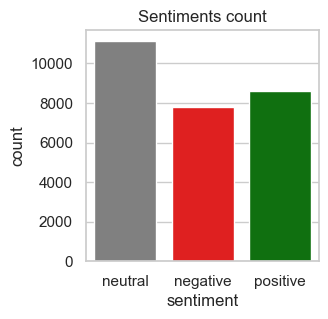

In [28]:
sns.set(style="whitegrid")
custom_palette = {'negative': 'red', 'positive': 'green', 'neutral': 'grey'}
plt.figure(figsize=(3, 3))
sns.countplot(x='sentiment', data=df, palette=custom_palette)
plt.title('Sentiments count')
plt.show()


### Tweet length vs. sentiment

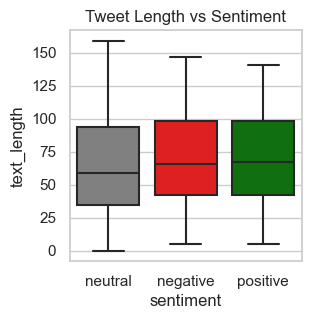

In [30]:
sns.set(style="whitegrid")
custom_palette = {'negative': 'red', 'positive': 'green', 'neutral': 'grey'}

df['text_length'] = df['text'].fillna('').apply(len)

plt.figure(figsize=(3, 3))
sns.boxplot(x='sentiment', y='text_length', data=df, palette=custom_palette)
plt.title('Tweet Length vs Sentiment')
plt.show()


            Target Variable Distribution           


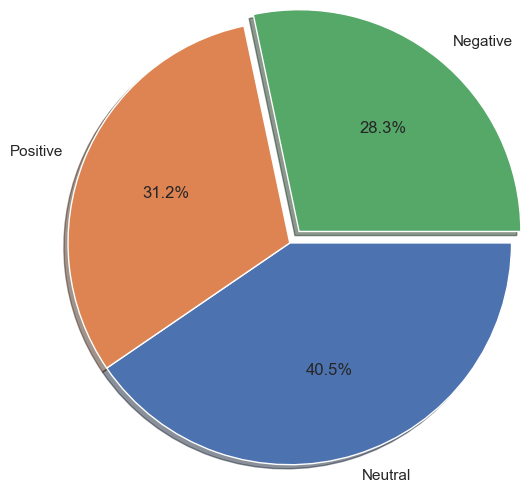

In [31]:
print('\033[1mTarget Variable Distribution'.center(55))
plt.pie(df['sentiment'].value_counts(), labels=['Neutral','Positive','Negative'], counterclock=False, shadow=True, 
        explode=[0,0,0.1], autopct='%1.1f%%', radius=1.5, startangle=0)
plt.show()

### Word Cloud (before processing)

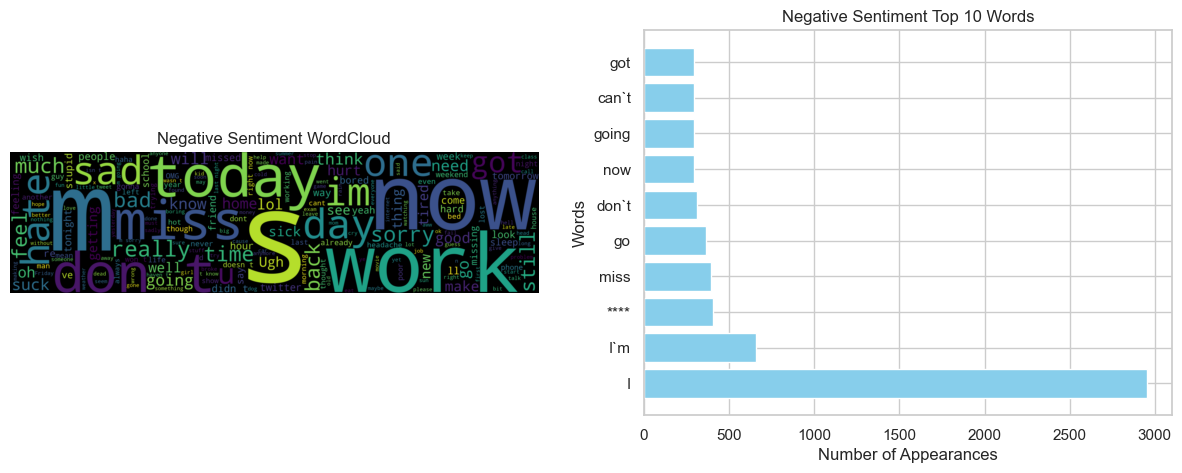

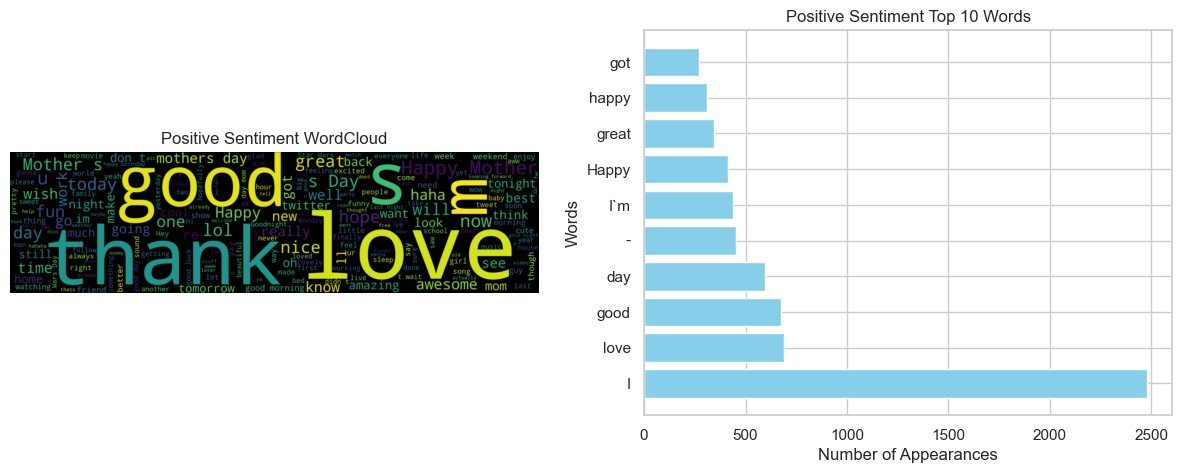

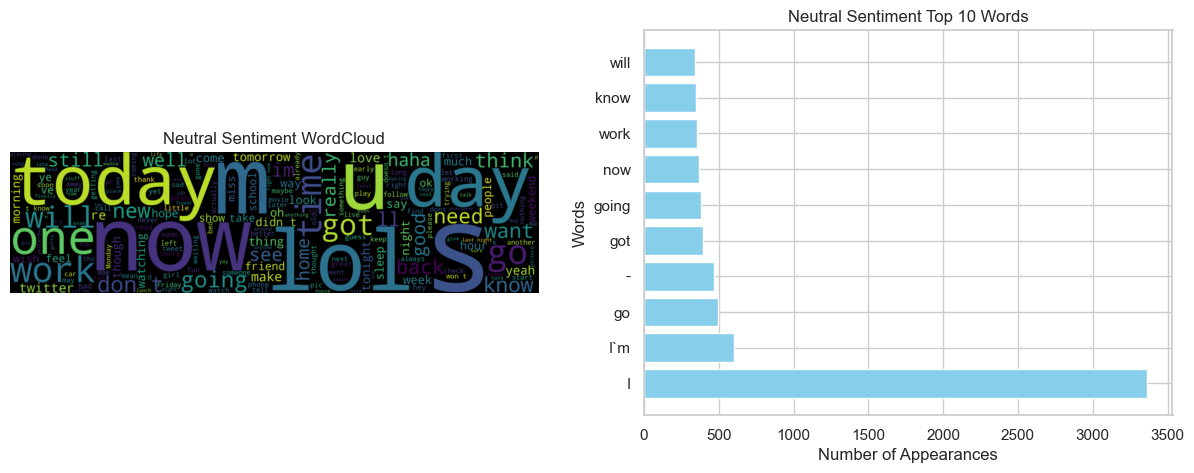

In [33]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from collections import Counter

negative_df = df[df['sentiment'] == 'negative']
positive_df = df[df['sentiment'] == 'positive']
neutral_df = df[df['sentiment'] == 'neutral']

def generate_wordcloud_and_bar(data, title):
    data_copy = data.copy()
    # removing eventually nan values from the 'text' column
    data_copy['text'].fillna('', inplace=True)
    #concatenate the list
    words = ' '.join(data_copy['text'])
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT' ])

     # Remove stopwords from cleaned_word before proceeding with word count
    cleaned_word = " ".join([word for word in cleaned_word.split() if word not in STOPWORDS])
    
    # wordcloud generation 
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', 
                          width=3000, height=800).generate(cleaned_word)
    
    # wordcloud display
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title + ' WordCloud')
    plt.axis('off')
    
    # frequent words
    plt.subplot(1, 2, 2)
    word_counts = Counter(cleaned_word.split())
    common_words = [word[0] for word in word_counts.most_common(10)]  # top 10 words
    common_counts = [word[1] for word in word_counts.most_common(10)]
    plt.barh(common_words, common_counts, color='skyblue')
    plt.title(title + ' Top 10 Words')
    plt.xlabel('Number of Appearances')
    plt.ylabel('Words')
    
    plt.show()

# Generating and displaying WordClouds and top words for each sentiment category cleaning
generate_wordcloud_and_bar(negative_df, 'Negative Sentiment')
generate_wordcloud_and_bar(positive_df, 'Positive Sentiment')
generate_wordcloud_and_bar(neutral_df, 'Neutral Sentiment')

In [34]:
#!pip install pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
from pyspark.sql import functions as F

#SparkContext and SparkSession initialization
sc = SparkContext("local[2]", "TwitterSentimentAnalysisApp")
spark = SparkSession(sc)

#csv parser
csv_path = "Tweets.csv"
df = spark.read.csv(csv_path, header=True, inferSchema=True)

def analyze_sentiment(text):
    # cleanup with class method
    cleaned_text = TextCleaner.clean_text(text)
    
    # err handle: case where there is no valid data
    if not cleaned_text:
        cleaned_text = ['unknown',  'sentiment']
    # TF-IDF Vectorizer - trained earlier
    # make sure 'cleaned_text' is a list of preprocessed text data
    vectorized_data = vectoriser.transform(cleaned_text)
    dense_data = vectorized_data.toarray()
    
    # the prediction is made with mnb model but based on performance change it
    #pred = mnb_model.predict(dense_data)
    pred = lr_model.predict(dense_data)
    label = pred.argmax()
    label_to_str = {
        0: 'negative',
        1: 'positive',
        2: 'neutral'
    }
    # map the predicted labels to statuses 
    return label_to_str.get(label, 2) # 'good sentiment' or wha

sentiment_udf = F.udf(analyze_sentiment)

# sentiment analysis to the df
df_with_sentiment = df.withColumn("result", sentiment_udf(df["text"]))

# results
df_with_sentiment.select("result", "text").show(100, truncate=False)

+--------+------------------------------------------------------------------------------------------------------------------------------------------+
|result  |text                                                                                                                                      |
+--------+------------------------------------------------------------------------------------------------------------------------------------------+
|negative| I`d have responded, if I were going there                                                                                                |
|negative| Sooo SAD I will miss you here in San Diego!!!                                                                                            |
|negative|my boss is bullying me...                                                                                                                 |
|neutral | what interview! leave me alone                                                           

In [35]:
sc.stop()